In [1]:
# Standard Libraries
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Evaluation
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Disable Warnings
import warnings
warnings.filterwarnings("ignore")


In [3]:
# Load the cleaned dataset
df_ml = pd.read_csv('../CSVs/MLB_First_Pitch_Swings_ML_Cleaned.csv')

In [5]:
# Initialize LabelEncoder
le = LabelEncoder()

# If 'target_encoded' is missing, create it
if 'target_encoded' not in df_ml.columns:
    df_ml['target_encoded'] = le.fit_transform(df_ml['target'])

# Verify encoding worked
print(df_ml[['target', 'target_encoded']].head())


         target  target_encoded
0          foul               0
1  weak_contact               3
2          foul               0
3          foul               0
4          foul               0


In [7]:
# Define features (X) and target (y)
X = df_ml.drop(columns=['target', 'target_encoded', 'launch_speed'], errors='ignore')  # Ensure target & launch_speed are removed
y = df_ml['target_encoded']  # Use encoded target variable

# Verify the columns are correct
print("Final Feature Columns:", X.columns.tolist())
print("Target Sample:", y.unique())  # Ensure encoding worked


Final Feature Columns: ['release_speed', 'pfx_z', 'plate_x', 'plate_z', 'zone', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot', 'release_spin_rate', 'release_extension', 'release_pos_y', 'pitch_type_CH', 'pitch_type_CS', 'pitch_type_CU', 'pitch_type_EP', 'pitch_type_FA', 'pitch_type_FC', 'pitch_type_FF', 'pitch_type_FO', 'pitch_type_FS', 'pitch_type_KC', 'pitch_type_KN', 'pitch_type_SC', 'pitch_type_SI', 'pitch_type_SL', 'pitch_type_ST', 'pitch_type_SV', 'pitch_type_Unknown', 'pitch_type_nan']
Target Sample: [0 3 2 1]


In [9]:
# Split into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Print split sizes
print("Training set size:", X_train.shape, y_train.shape)
print("Testing set size:", X_test.shape, y_test.shape)


Training set size: (44528, 34) (44528,)
Testing set size: (11132, 34) (11132,)


In [11]:
# Apply SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Print resampled sizes
print("Resampled training set size:", X_train_resampled.shape, y_train_resampled.shape)


Resampled training set size: (67792, 34) (67792,)


In [13]:
# Train Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_resampled, y_train_resampled)

# Predict on test set
y_pred_log = log_reg.predict(X_test)

# Display results
print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_log))


Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.45      0.26      0.33      4237
           1       0.23      0.47      0.31      1684
           2       0.40      0.54      0.46      2751
           3       0.26      0.18      0.21      2460

    accuracy                           0.34     11132
   macro avg       0.34      0.36      0.33     11132
weighted avg       0.36      0.34      0.33     11132



In [15]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_resampled, y_train_resampled)

# Predict on test set
y_pred_rf = rf.predict(X_test)

# Display results
print("Random Forest Results:")
print(classification_report(y_test, y_pred_rf))


Random Forest Results:
              precision    recall  f1-score   support

           0       0.43      0.47      0.45      4237
           1       0.29      0.33      0.31      1684
           2       0.53      0.51      0.52      2751
           3       0.30      0.24      0.27      2460

    accuracy                           0.41     11132
   macro avg       0.39      0.39      0.39     11132
weighted avg       0.41      0.41      0.41     11132



In [17]:
# Train XGBoost
xgb = XGBClassifier(eval_metric='mlogloss', random_state=42)
xgb.fit(X_train_resampled, y_train_resampled)

# Predict on test set
y_pred_xgb = xgb.predict(X_test)

# Display results
print("XGBoost Results:")
print(classification_report(y_test, y_pred_xgb))


XGBoost Results:
              precision    recall  f1-score   support

           0       0.44      0.58      0.50      4237
           1       0.29      0.28      0.29      1684
           2       0.56      0.49      0.53      2751
           3       0.33      0.21      0.25      2460

    accuracy                           0.43     11132
   macro avg       0.41      0.39      0.39     11132
weighted avg       0.42      0.43      0.42     11132



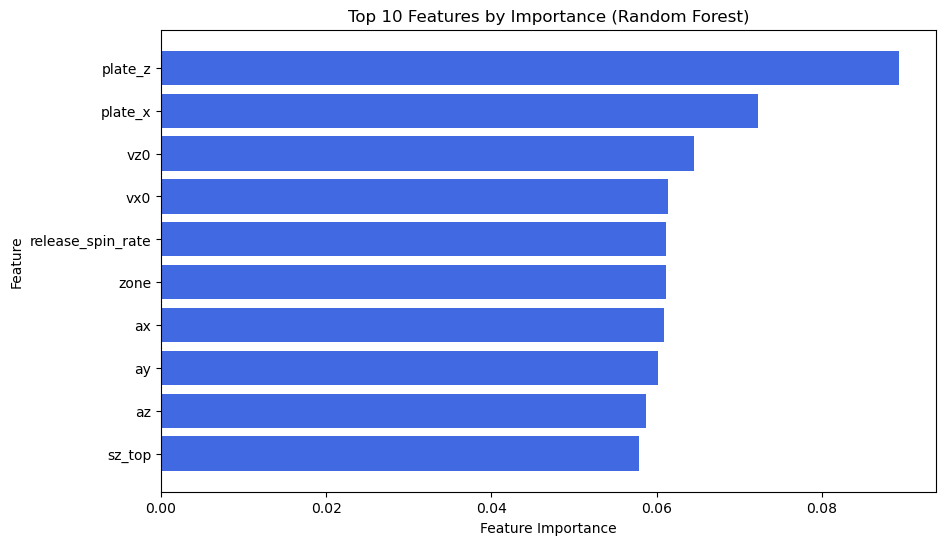

In [19]:
# Get feature importances from Random Forest
importances = rf.feature_importances_
feature_names = X_train.columns

# Sort feature importance
sorted_idx = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_idx]
sorted_features = np.array(feature_names)[sorted_idx]

# Plot feature importance
plt.figure(figsize=(10,6))
plt.barh(sorted_features[:10], sorted_importances[:10], color='royalblue')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 10 Features by Importance (Random Forest)")
plt.gca().invert_yaxis()  # Flip the order to match bar length
plt.show()

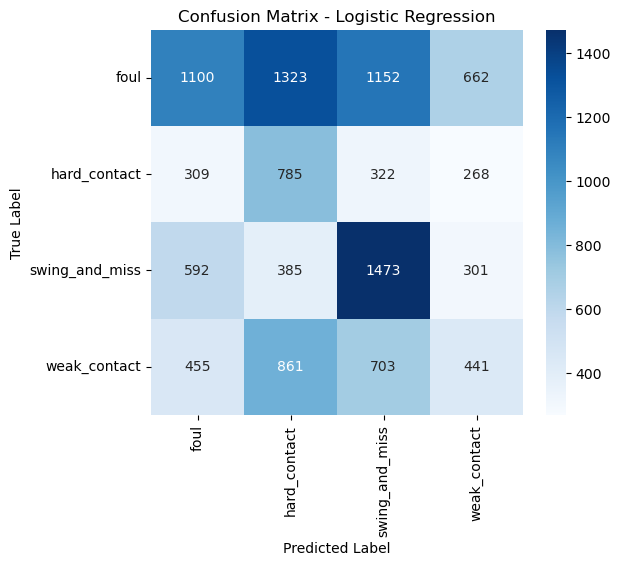

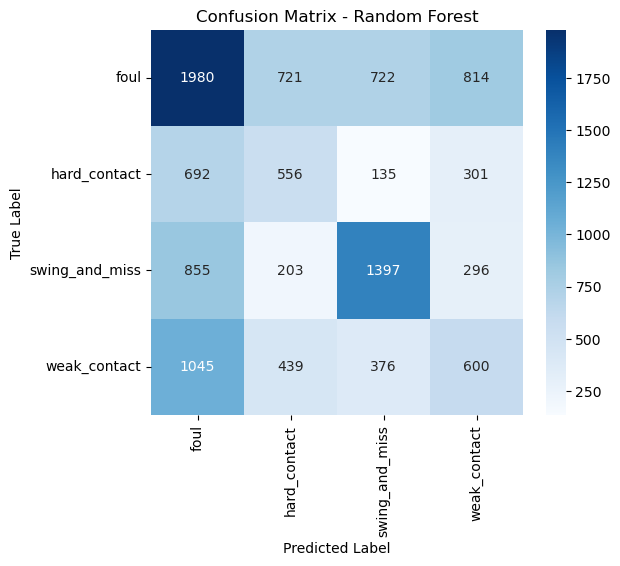

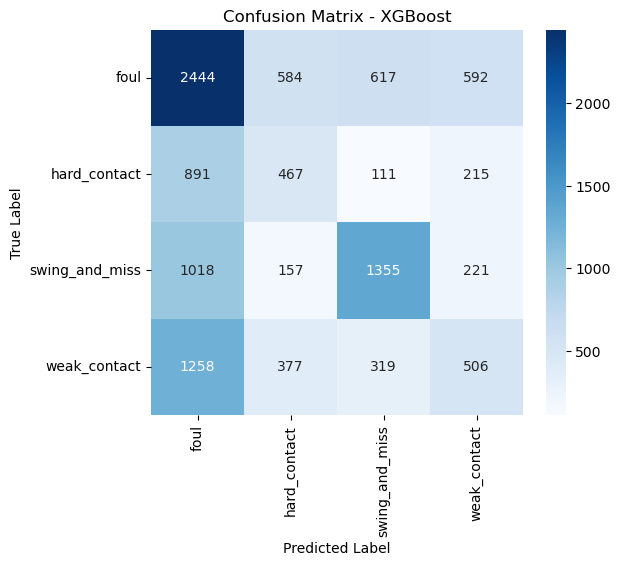

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define a function to plot confusion matrices
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

# Plot for Logistic Regression
plot_confusion_matrix(y_test, log_reg.predict(X_test), "Logistic Regression")

# Plot for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest")

# Plot for XGBoost
plot_confusion_matrix(y_test, xgb.predict(X_test), "XGBoost")
